# Questions Clustering - English

## Expected
Questions to be sorted out such that the response to the whole cluster is same.

<!--### To Do-->
Author: Sunanda Bansal  
Organization: Dataperformers  
License: CC BY-NC  
Date: 24 Mar, 2020 (Start)  

In [2]:
import re
import regex
import os
import csv
import sys
import json
import time
import scipy
import socket
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer   
from sklearn import metrics   
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.pairwise import paired_distances as sklearn_paired_distances

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

# importing personal development helper classes
import utils

Using TensorFlow backend.


In [3]:
pd.__version__

'0.25.3'

## Define variables here

Mostly the code will be intended to use with arguments that can be passed in comman line, but jupyter notebook doesn't handle `argparse` well, so the Args class is a temporary way to write the code assumming the variables to be an attribute of an object.

In [4]:
class Args:
    def __init__(self):
        # The very big scraped file, give absolute path, outside the repo
        # self.filename = "query_result_2020-03-27T19_12_30.866993Z.csv"
        self.filename = "covid_questions_2020-04-21.csv"
        
        # path to the file
        self.dataset = f"data/{self.filename}"    
        
        # suffix used to create
        self.suffix = "_".join([word for word in self.filename.split("_") if not word.isalpha()])[:-4]
        self.vector_mode = "tfidf"
        self.n_topics = 230
        self.dist_thresh = 1.5
        self.lang = "en"
args=Args()

In [5]:
# Disable (FALSE) displaying warnings from the OpenMP* run-time library during program execution.
os.environ['KMP_WARNINGS'] = "FALSE"

## Functions

In [6]:
# Regex functions
def surrounding(word,area=2):
    # A funtion, yet to be defined, that can be used to extract text around keywords
    return

def fuzzy_match(word,pattern):
    '''
        Fuzzy matching function to be used with .apply() of pandas

        Reason - Fuzzy matching is available in regex package, not in re package, 
        therefore fuzzy matching is not a part of pandas string matching functions
    '''
 
    if regex.search(pattern, word, re.IGNORECASE):
        return True
    else:
        return False    
    
# Language Detection
from langdetect import detect
def detect_lang(text):
    # Used to detect language of the question
    try:
        return detect(text)
    except:
        return "unidentifiable"   

### Natural Lanuage Proprocessing Functions
   
Preprocessing done -
   1. Normalizing accents  
   2. Removing non alphabetic characters  
   3. Casefolding  

Preprocessing not done -
   1. Stopword removal - For questions, stopwords are essential and thus are retained
   2. Stemming - For rule based analysis it might be useful to keep the words as they are, for LSA, the questions don't have enough variation in content to benefit for stemming

In [7]:
import re
import nltk
import unidecode

# Regular expression to select all that is not alphabet
# @maybe allow numbers as well
alpha_regex = re.compile('[^a-zA-Z]')

from nltk.corpus import stopwords as sw
if args.lang == "en": stopwords = sw.words('english')
if args.lang == "fr": stopwords = sw.words('french')

from nltk.stem.snowball import SnowballStemmer
if args.lang == "en": stemmer = SnowballStemmer("english")
if args.lang == "fr": stemmer = SnowballStemmer("french")

def tokenize(text):
    '''
        1. Normalized accents
        2. Splits at non alpbhaetic character (@maybe need to revisit for french text)
        3. Caasefolds
    '''    
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # Handle french accents in text
            word = unidecode.unidecode(word)
            
            # Split at every non alphabet character occurrence
            clean_words = alpha_regex.sub(' ', word).split()
            
            # Casefold
            tokens.extend([word.lower() for word in clean_words])
    
    # Return tokens
    return tokens

def stem(word):
    return stemmer.stem(word).strip()

def preprocess(text):    
    tokenized = tokenize(text)
    # cleaned = [word for word in tokenized if word not in stopwords and word != '']
    # stemmed = [stem(word) for word in cleaned]
    return ' '.join(tokenized)

## Dataset

In [8]:
# Read dataset
dataset = pd.read_csv(args.dataset)
print(f"Dataset has {len(dataset)} documents")

# Detect Language
dataset["detected_lang"] = dataset.question.apply(detect_lang)

print(f"Dataset has {len(dataset[dataset.detected_lang=='en'])} english documents and {len(dataset[dataset.detected_lang=='fr'])} french documents")
print(f"{len(dataset)-len(dataset[dataset.detected_lang=='en'])-len(dataset[dataset.detected_lang=='fr'])} documents will not be processed because of different language")

Dataset has 5054 documents
Dataset has 2031 english documents and 2724 french documents
299 documents will not be processed because of different language


In [9]:
# Translation Questions from French to English
if "translated_question" not in dataset.columns:
    dataset["translated_question"] = np.nan

translated_df_path = f"data/{os.path.basename(args.filename)[:-4]}_fr.csv"
fr = pd.DataFrame(columns=["question","translated_question"])
if os.path.exists(translated_df_path):
    fr_csv = pd.read_csv(translated_df_path, index_col=0)
    fr = fr.combine_first(fr_csv)
    dataset.update(fr.translated_question)
    
# Any french questions that need to be translated?
fr_questions = dataset[
                        (dataset.detected_lang == "fr") & 
                        (dataset.translated_question.isnull())
                      ][["question","translated_question"]]

if len(fr_questions)>0:    
    try:
        from googletrans import Translator
        translator = Translator()
        translations = []
        for q in list(fr_questions.question):
            translations.append(translator.translate(q).text)
        print("Using google translate.")
    except:
        # HACK for when your IP has been blocked
        translations_file_path = f"data/{os.path.basename(args.filename)[:-4]}_fr_translations.txt"
        if os.path.exists(translations_file_path):   
            # Delete if already exists
            os.remove(translations_file_path)
        
        # Create file and initialize empty
        os.mknod(translations_file_path)      
        translations = []
        
        while (len(translations) != len(fr_questions)):
            print(f"Translate the output french to english using gogle translate and copy this into this file - {translations_file_path} \n{'-'*100}")
            print(*fr_questions.question.tolist(),sep="\n")
            # Translate the output french to english using gogle translate 
            # and copy this into a text file save as {filename}_fr_translated.txt in data folder
            input(f"{'-'*100}\nPress Enter to continue...")
            
            with open(translations_file_path,"r") as f:
                translations = f.read().split("\n")  
            
    fr_questions.translated_question = translations
    dataset.update(fr_questions.translated_question)
    dataset[dataset.detected_lang == "fr"][["question","translated_question"]].to_csv(translated_df_path)

Using google translate.


In [10]:
# Preprocess questions
eng = dataset[dataset.detected_lang == "en"].question.apply(preprocess).to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.apply(preprocess).to_frame(name="text")
dataset["text"] = eng.combine_first(french).dropna()

# Drop
dataset = dataset.dropna(subset=['text'])

print(f"Dataset has {len(dataset)} english documents (translated and otherwise)")

Dataset has 4755 english documents (translated and otherwise)


In [11]:
# dataset[(dataset.language != "en") & (dataset.detected_lang == "en")]

In [12]:
# dataset[(dataset.language == "en") & (dataset.detected_lang != "en")]

### Length analysis for situations

In [13]:
dataset["len"] = dataset.text.apply(lambda x: len(x.split()))

In [14]:
# Set default value
dataset["cluster"] = "unclassified"

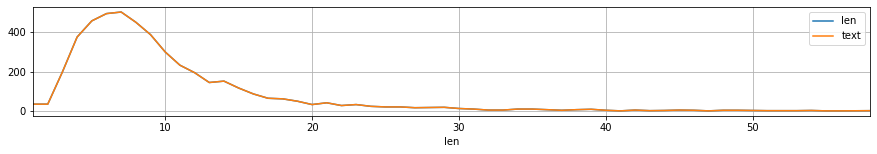

In [15]:
dataset[dataset.len<60].groupby("len")["len","text"].count().plot(figsize=(15,2),grid=True)

## Linguistic Features

In [16]:
import spacy
from spacy import displacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp_en = spacy.load("en_core_web_sm")
# nlp_fr = spacy.load("fr_core_news_md")

In [17]:
# Get one columns with questions
dataset["ques_en"] = dataset[dataset.detected_lang == "en"].question
dataset.loc[dataset.detected_lang == "fr","ques_en"] = dataset[dataset.detected_lang == "fr"].translated_question

In [18]:
dataset["spacy_doc"] = dataset.ques_en.apply(nlp_en)

In [19]:
# Let's get all the tuples in the whole corpus
def get_tuples(doc):  
    tuples = []
    if type(doc) == str:
        doc = nlp_en(doc)
    for sentence in doc.sents:  
        for token in sentence:            
            # Get SV tuples
            if "nsubj" in token.dep_:                  
                for sibling in token.head.children:
                    if sibling.dep_ in ["dobj","acomp"]:
                        tuples.append((token.lemma_.lower(), token.head.lemma_.lower(), sibling.lemma_.lower(), sibling.dep_))  
    return tuples

# Let's get all the tuples in the whole corpus
def get_dependencies(doc):  
    dependencies = []
    if type(doc) == str:
        doc = nlp_en(doc)
    for sentence in doc.sents:  
        for token in sentence:            
            dependencies.append((token.lemma_.lower(), token.dep_, token.head.lemma_.lower()))  
    return dependencies

In [389]:
from scipy.sparse import coo_matrix
def get_vectors(rows, features):
    mtxr, mtxc, mtxv = [], [], [] 
    for i,row in enumerate(rows):
        sequence = [features.index(feat_val) for feat_val in row if feat_val in features]
        mtxr.extend([i]*len(sequence))
        mtxv.extend([1]*len(sequence))
        mtxc.extend([j for j in sequence])
    return coo_matrix((mtxv, (mtxr, mtxc)), shape=(len(rows), len(features)))

def interpret_vectors(vectors, features):
    if np.array(vectors).shape[-1:][0] != len(features):
        raise Exception("Vector size does not match number of features")  
    
    if len(np.array(vectors).shape) == 1:      
        vector = vectors # single vector 
        return [feat for val,feat in zip(vector, features) if val>0]
    else:        
        return [[feat for val,feat in zip(vector, features) if val>0] for vector in vectors]       

In [20]:
dataset["tuples"] = dataset.spacy_doc.apply(get_tuples)

# Dataframe with all the unique tuples
tuples = list(set([t for row in dataset["tuples"].tolist() for t in row]))

In [133]:
dataset["dependencies"] = dataset.spacy_doc.apply(get_dependencies)

# Dataframe with all the unique dependencies
# dependencies = pd.DataFrame([t for row in dataset["dependencies"].tolist() for t in row], columns=["dep","rel","head"])
# dependencies = dependencies.drop_duplicates()
dependencies = list(set([t for row in dataset["dependencies"].tolist() for t in row]))

In [84]:
dataset["dependency_vector"] = list(get_vectors(dataset.dependencies, dependencies).toarray())

In [85]:
dataset["tuple_vector"] = list(get_vectors(dataset.tuples, tuples).toarray())

In [86]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,translated_question,text,len,cluster,ques_en,spacy_doc,tuples,dependencies,dependency_vector,tuple_vector
0,2020-03-18 17:57:10.427,7302144e-abbe-4fa4-aaf1-cf5eb674a862,en,What is Dialogue's position on sick notes?,en,NaN,what is dialogue s position on sick notes,8,unclassified,What is Dialogue's position on sick notes?,"(What, is, Dialogue, 's, position, on, sick, n...",[],"[(what, attr, be), (be, ROOT, be), (dialogue, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2020-03-19 11:16:11.354,5a65a4bd-05aa-4ca8-b6da-5f807bde3294,en,What are Dialogue services?,en,NaN,what are dialogue services,4,unclassified,What are Dialogue services?,"(What, are, Dialogue, services, ?)",[],"[(what, attr, be), (be, ROOT, be), (dialogue, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2020-03-19 14:17:16.246,6d60c897-dd96-483d-b528-b65fcae4c1b0,en,Should I practice social distancing?,en,NaN,should i practice social distancing,5,unclassified,Should I practice social distancing?,"(Should, I, practice, social, distancing, ?)","[(-pron-, practice, distancing, dobj)]","[(should, aux, practice), (-pron-, nsubj, prac...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2020-03-19 14:00:19.88,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,LP TEST question,lp test question,3,unclassified,LP TEST question,"(LP, TEST, question)",[],"[(lp, compound, question), (test, compound, qu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2020-03-19 14:16:05.351,f264fd4b-de03-4dc0-8531-fa9d0a1b0633,en,I'd love to know how long I can be contagious?,en,NaN,i d love to know how long i can be contagious,11,unclassified,I'd love to know how long I can be contagious?,"(I, 'd, love, to, know, how, long, I, can, be,...","[(-pron-, be, contagious, acomp)]","[(-pron-, nsubj, love), (would, aux, love), (l...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# pd.get_dummies(dataset.dependencies.explode()).reset_index().groupby("index").apply(np.sum)
# datatset["tuple_vector"] = pd.get_dummies(dataset.tuples.explode()).reset_index().groupby("index").apply(np.sum).tolist()
# v = vectorized_tuples.set_index("index").loc[5040].rename("vector_val")
# s.explode().reset_index()
# dependencies.combine_first(pd.DataFrame(values,columns=dependencies.columns))
# dataset[dataset["tuples"].apply(lambda x : ("-pron-","do","what","dobj") in x)==True]

## Rules
Note: The order of these rules matters in resolving conflicts

In [94]:
# Separate very long questions out
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.len > 15)
                , "cluster" ] = "too-much-information"

In [95]:
# Statistics
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("cases",case=False)|
                        dataset.text.str.contains("dea(?:th|d)(?:ly)?",case=False)|
                        dataset.text.str.contains("died",case=False)|
                        dataset.text.str.contains("(?:mortality|death|fatality) rate",case=False)|
                        dataset.text.str.contains("statistic",case=False)|
                        (
                            dataset.text.str.contains("how",case=False)&
                            dataset.text.str.contains("many",case=False)&
                            dataset.text.str.contains("people",case=False)
                        )
                    )
                , "cluster" ] = "situation-stats"

In [96]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\b(?:animal|bird|cat|dog|pet)s?\b",case=False))
                , "cluster" ] = "covid-transmission-animals"

In [97]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("mask",case=False)|
                        dataset.text.str.contains("glove",case=False)
                    )
                , "cluster" ] = "covid-precaution-gear"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("wash",case=False)
                    )
                , "cluster" ] = "covid-precaution-disinfection"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"\bisolat",case=False)|
                        dataset.text.str.contains(r"\bsocial dist",case=False)|
                        dataset.text.str.contains(r"\bconfine",case=False)
                    )
                , "cluster" ] = "covid-precaution-isolation"

In [98]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("go (?:on|to|for|out)",case=False)|
                                dataset.text.str.contains("walk",case=False)
                            )&
                            (
                                dataset.text.str.contains("allow",case=False)|
                                dataset.text.str.contains("can",case=False)|
                                dataset.text.str.contains("ok|okay",case=False)|
                                dataset.text.str.contains("should|shall",case=False)
                            )
                        )|
                        (
                            dataset.text.str.contains("lockdown",case=False)|
                            dataset.text.str.contains(r"\bopen\b",case=False)|
                            dataset.text.str.contains(r"\bclose",case=False)
                        )
                    )
                , "cluster" ] = "situation-lockdown"



In [99]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("if i (?:have|am|m)",case=False)
                    )
                , "cluster" ] = "covid-whatif"

In [100]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"i (?:have|ve)",case=False)|
                        (
                            dataset.text.str.contains(r"\b(?:has|have)",case=False)&
                            dataset.text.str.contains(r"symptom",case=False)
                        )
                        # dataset.text.str.contains(r"(?:i (?:think|feel) )?i \b(?:have|ve|am|m)\b",case=False)
                    )
                , "cluster" ] = "personal-symptoms"

In [101]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"\btransmi|contract|catch|spread|airborne",case=False)
                    )                
                , "cluster" ] = "covid-transmission"

dataset.loc[
                    (dataset.cluster=="covid-transmission") & 
                    (
                        dataset.text.str.contains("again",case=False)|
                        dataset.text.str.contains("twice",case=False)
                    )                
                , "cluster" ] = "covid-transmission-twice"

In [102]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                            (
                                dataset.text.str.contains("(?:corona|covid)",case=False)|
                                dataset.text.str.contains("virus",case=False)
                            )&
                            (
                                dataset.text.str.contains("live|stay|survive",case=False)
                            )&
                            (
                                dataset.text.str.contains("on",case=False)
                            )
                    )
                , "cluster" ] = "covid-life"

In [103]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("infected",case=False)|
                        dataset.text.str.contains("infection",case=False)
                    )                
                , "cluster" ] = "covid-infection"

In [104]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                         dataset.text.str.contains("prevent",case=False)|
#                         dataset.text.str.contains("protect",case=False)|
#                         dataset.text.str.contains("precaution",case=False)|
#                         dataset.text.str.contains("safety",case=False)|
#                         (
#                             dataset.text.str.contains("keep",case=False)&
#                             dataset.text.str.contains("safe",case=False)
#                         )
#                     )               
#                 , "cluster" ] = "covid-precaution"

In [105]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                 dataset.text.str.contains("corona",case=False)|
#                                 dataset.text.str.contains("virus",case=False)
#                             )&
#                             (
#                                 dataset.text.str.contains("kills",case=False)
#                             )
#                     )                
#               , "cluster" ] = "covid-kill"

In [106]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 (
#                                     dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                     dataset.text.str.contains("corona",case=False)|
#                                     dataset.text.str.contains("virus",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("fight",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("help",case=False)
#                                 )
#                             )|
#                             (
#                                 dataset.text.str.contains("mask",case=False)|
#                                 dataset.text.str.contains("glove",case=False)
#                             )
#                         )                
#                     , "cluster" ] = "covid-fight"

In [107]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("treatment",case=False)|
                        dataset.text.str.contains("cure",case=False)|
                        dataset.text.str.contains("vaccine",case=False)|
                        dataset.text.str.contains("medic",case=False)
                    )                
                , "cluster" ] = "covid-med"

In [108]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("incubate",case=False)|
                        dataset.text.str.contains("incubation",case=False)
                    )      
                , "cluster" ] = "covid-incubation"

In [109]:
# dataset.loc[                     
#                        (dataset.cluster=="unclassified") & (
# #                         dataset.text.str.contains(r"\bgo\b",case=False)&
#                         (
#                             dataset.text.str.contains("hospital",case=False)|                            
#                             dataset.text.str.contains(r"\bER\b",case=False)
#                         )
#                     )
#                , "cluster" ] = "hospital"

In [110]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("diff",case=False)|
                        dataset.text.apply(fuzzy_match, pattern="(?:distinguish){e<=3}")
                    )                
                , "cluster" ] = "covid-versus"

In [111]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("tested",case=False)|
                        dataset.text.str.contains("test",case=False)
                    )                
                , "cluster" ] = "personal-testing"

dataset.loc[
                    (dataset.cluster=="personal-testing") & 
                    (
                        dataset.text.str.contains("(?:tested|test)",case=False) &
                        dataset.text.str.contains("where",case=False)
                    )                
                , "cluster" ] = "personal-testing-location"

In [112]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("recover",case=False)
                    )                
                , "cluster" ] = "covid-recovery"

In [113]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("at risk",case=False)|
                        (
                            dataset.text.str.contains("more",case=False) &
                            dataset.text.str.contains("risky|dangerous",case=False)
                        )
                    )                
                , "cluster" ] = "covid-vulnerable"

In [114]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("dangerous",case=False)|
                        dataset.text.str.contains("risk",case=False)
                    )                
                , "cluster" ] = "covid-contagious"

In [115]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\bsymptom",case=False))                
                , "cluster" ] = "covid-symptoms"

In [116]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:whats|what (?:is|s))")
                        ) & 
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
                            dataset.text.str.contains("corona",case=False)
                        )
                    )                
                , "cluster" ] = "covid-what"

In [117]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("how",case=False) &
                                dataset.text.str.contains("long",case=False)
                            )|
                            dataset.text.str.contains("when",case=False)
                        )&
                            dataset.text.str.contains("will",case=False)&
                        (
                            dataset.text.str.contains("last|end|over|normal|done",case=False)
                        )
                    )                
                , "cluster" ] = "situation-future"

In [118]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.str.contains("how|when|where",case=False) 
                        )&
                            dataset.text.str.contains("did",case=False)&
                        (
                            dataset.text.str.contains("start|begin|began",case=False)
                        )
                    )                
                , "cluster" ] = "situation-past"

In [119]:
features = dataset.cluster.unique().tolist()

In [ ]:
features

In [ ]:
# Clustering stats
dataset.groupby("cluster")["question"].count()

In [ ]:
# Saving the files
path = f"output/simpleFiltered_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"Rules based output saved to {path}")

## Analysing dependencies

In [182]:
dependency_counts = pd.DataFrame(dependencies).apply(tuple, axis=1).to_frame(name="Dependency")
dependency_counts = dependency_counts.join(pd.DataFrame(dataset.groupby("cluster").dependency_vector.apply(sum).apply(pd.Series)).T)

In [183]:
dependency_counts

,Dependency,covid-contagious,covid-incubation,covid-infection,covid-life,covid-med,covid-precaution-disinfection,covid-precaution-gear,covid-precaution-isolation,covid-recovery,...,covid-whatif,personal-symptoms,personal-testing,personal-testing-location,situation-future,situation-lockdown,situation-past,situation-stats,too-much-information,unclassified
0,"(more, dobj, get)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"(-pron-, poss, region)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,1
2,"(-pron-, dobj, do)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0
3,"(eye, dobj, have)",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"(occur, ROOT, occur)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18630,"(to, quantmod, 14)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18631,"(place, pobj, at)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
18632,"(in, prep, ball)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18633,"(have, relcl, daughter)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [191]:
def get_cat_freq(row):
    return sum([1 for val in row if val>0])

In [196]:
dependency_counts["cat_freq"] = dependency_counts[features].apply(get_cat_freq,axis=1)

In [332]:
dependency_counts["total_freq"] = dependency_counts[features].apply(sum,axis=1)

In [333]:
dependency_counts.head()

,Dependency,covid-contagious,covid-incubation,covid-infection,covid-life,covid-med,covid-precaution-disinfection,covid-precaution-gear,covid-precaution-isolation,covid-recovery,...,personal-testing,personal-testing-location,situation-future,situation-lockdown,situation-past,situation-stats,too-much-information,unclassified,cat_freq,total_freq
0,"(more, dobj, get)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,"(-pron-, poss, region)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2,1,3,5
2,"(-pron-, dobj, do)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,1,6
3,"(eye, dobj, have)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,"(occur, ROOT, occur)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,2


In [343]:
dependency_counts[dependency_counts.total_freq>1].sort_values(by="total_freq",ascending=False)["total_freq"][:10]

16707    1906
1840     1432
12871     743
13185     684
2758      682
3671      476
8314      425
12748     346
4734      336
1696      283
Name: total_freq, dtype: int64

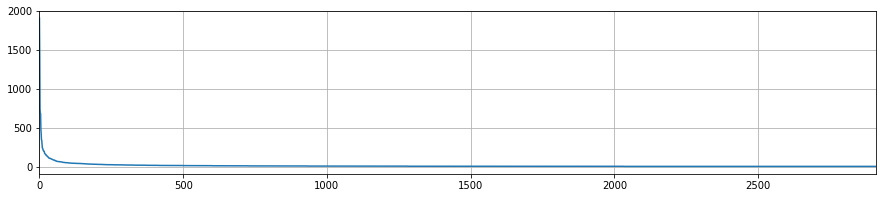

In [406]:
# Frequency of dependencies, (x,y) is y dependencies have x total frequency
dependency_counts[dependency_counts.total_freq>2].sort_values(by="total_freq",ascending=False)["total_freq"].plot(figsize=(15,3), grid=True, use_index=False)

In [408]:
dataset["dependency_vector"] = list(get_vectors(dataset.dependencies, dependency_counts[dependency_counts.total_freq>2].Dependency.values.tolist()).toarray())

In [409]:
dataset.loc[2,"dependencies"]

[('should', 'aux', 'practice'),
 ('-pron-', 'nsubj', 'practice'),
 ('practice', 'ROOT', 'practice'),
 ('social', 'amod', 'distancing'),
 ('distancing', 'dobj', 'practice'),
 ('?', 'punct', 'practice')]

In [410]:
interpret_vectors(dataset.loc[2,"dependency_vector"], dependency_counts[dependency_counts.total_freq>2].Dependency.values.tolist())

[('distancing', 'dobj', 'practice'),
 ('practice', 'ROOT', 'practice'),
 ('-pron-', 'nsubj', 'practice'),
 ('?', 'punct', 'practice'),
 ('social', 'amod', 'distancing')]

In [348]:
# Frequency of dependencies, (x,y) is y dependencies have x total frequency
# dependency_counts.sort_values("total_freq",ascending=False).groupby("total_freq")["Dependency"].count().sort_values(ascending=False).plot(figsize=(15,5), grid=True, use_index=False, xticks=range(0,120,5))

In [349]:
# dependency_counts.sort_values("cat_freq",ascending=False).groupby("cat_freq").count()

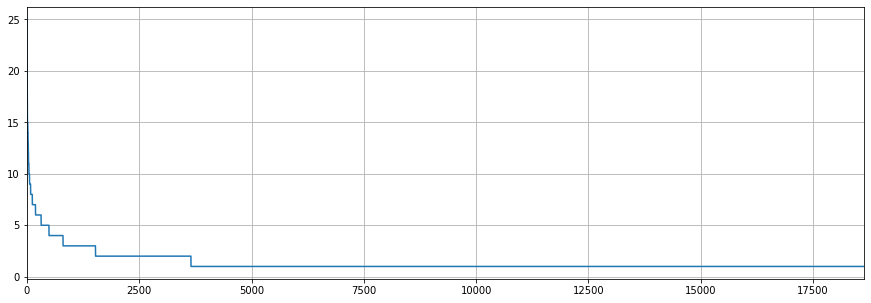

In [354]:
# Category Frequency of Dependencies, (x,y) is y dependencies have appeared in x distinct categories
dependency_counts.sort_values(by="cat_freq",ascending=False)["cat_freq"].plot(figsize=(15,5),grid=True, use_index=False)

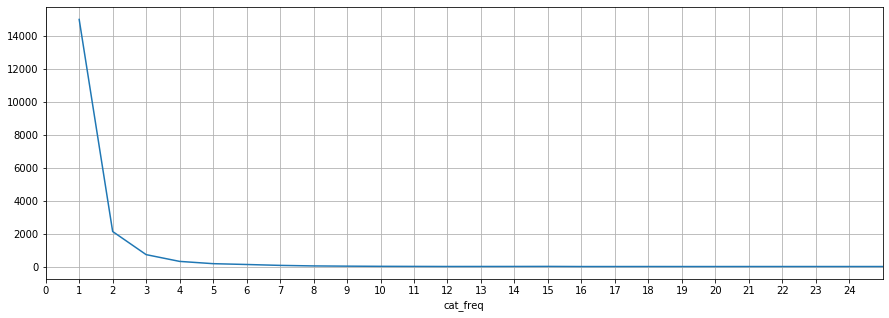

In [254]:
# Category Frequency of Dependencies, (x,y) is y dependencies have appeared in x distinct categories
dependency_counts.groupby("cat_freq").count()["Dependency"].plot(figsize=(15,5),grid=True, xticks=range(0,25,1))

In [267]:
# later - Drop the stopword like dependencies, as in the ones which appear
# Keeping the stopword dependencies for now, since I want to see them all, before discarding carelessly
dependency_counts[dependency_counts.cat_freq > 20]

,Dependency,covid-contagious,covid-incubation,covid-infection,covid-life,covid-med,covid-precaution-disinfection,covid-precaution-gear,covid-precaution-isolation,covid-recovery,...,personal-testing,personal-testing-location,situation-future,situation-lockdown,situation-past,situation-stats,too-much-information,unclassified,cat_freq,total_freq
1840,"(?, punct, be)",53,19,29,2,36,6,10,12,6,...,33,1,4,18,0,59,202,409,25,1432
2758,"(-pron-, nsubj, be)",18,0,9,2,5,3,7,7,5,...,9,0,1,16,0,3,272,190,21,682
3671,"(the, det, virus)",9,5,4,78,2,1,5,0,4,...,5,0,0,4,0,10,97,120,21,476
16707,"(be, ROOT, be)",67,22,31,2,43,8,11,16,9,...,39,1,5,31,0,75,325,521,25,1906



unclassified [1490]
-------------------

                      Dependency  unclassified
16707             (be, ROOT, be)           521
1840              (?, punct, be)           409
2758         (-pron-, nsubj, be)           190
13185           (what, attr, be)           122
3671           (the, det, virus)           120
...                          ...           ...
9360           (be, aux, travel)             2
6764           (same, acomp, be)             2
3583           (what, det, kind)             2
636        (between, prep, link)             2
11097  (temperature, dobj, take)             2

[1430 rows x 2 columns]

covid-precaution-isolation [0089]
---------------------------------

                       Dependency  covid-precaution-isolation
16707              (be, ROOT, be)                          16
12871       (-pron-, nsubj, have)                          12
1840               (?, punct, be)                          12
12748         (how, advmod, long)                  

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


                  Dependency  covid-symptoms
16707         (be, ROOT, be)             356
4734     (the, det, symptom)             294
13185       (what, attr, be)             268
1696    (symptom, nsubj, be)             265
1840          (?, punct, be)             265
...                      ...             ...
6023       (if, mark, start)               2
8123       (and, cc, throat)               2
636    (between, prep, link)               2
2348       (for, prep, last)               2
17945        (one, attr, be)               2

[208 rows x 2 columns]

situation-lockdown [0162]
-------------------------

                    Dependency  situation-lockdown
16176           (go, ROOT, go)                  91
3757       (-pron-, nsubj, go)                  86
6382            (?, punct, go)                  84
7285            (can, aux, go)                  51
8199            (to, prep, go)                  49
...                        ...                 ...
18005       (street, pobj

                       Dependency  covid-transmission
3671            (the, det, virus)                  54
16707              (be, ROOT, be)                  46
1840               (?, punct, be)                  39
9920       (spread, ROOT, spread)                  31
15021  (transmit, ROOT, transmit)                  30
...                           ...                 ...
8085          (-pron-, nsubj, do)                   2
16122        (can, aux, minimize)                   2
4940            (there, expl, be)                   2
18554            (what, dobj, do)                   2
1645   (transmissible, acomp, be)                   2

[163 rows x 2 columns]

personal-testing-location [0043]
--------------------------------

                      Dependency  personal-testing-location
2719        (get, auxpass, test)                         30
11396      (where, advmod, test)                         28
16105         (test, ROOT, test)                         26
2409            (can

                         Dependency  covid-transmission-twice
4388         (-pron-, nsubj, catch)                         9
4862              (can, aux, catch)                         8
13283          (catch, ROOT, catch)                         8
5567         (again, advmod, catch)                         6
173           (-pron-, dobj, catch)                         6
9074              (?, punct, catch)                         6
1840                 (?, punct, be)                         4
16707                (be, ROOT, be)                         4
2758            (-pron-, nsubj, be)                         4
12311             (,, punct, catch)                         3
7248          (possible, acomp, be)                         3
3671              (the, det, virus)                         3
2935     (contract, ROOT, contract)                         2
11917          (can, aux, contract)                         2
105                (to, aux, catch)                         2
10752   

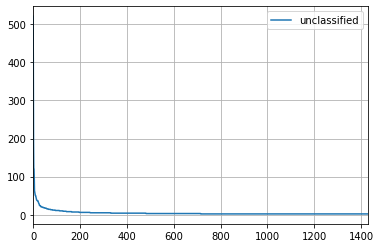

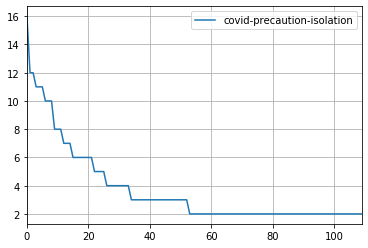

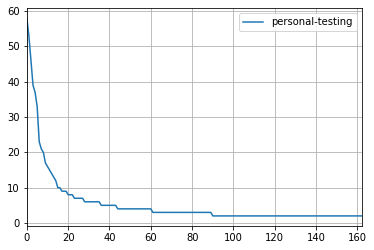

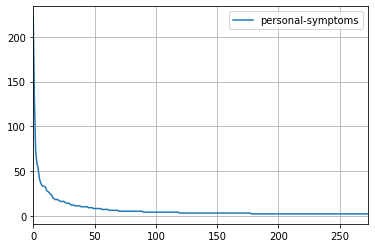

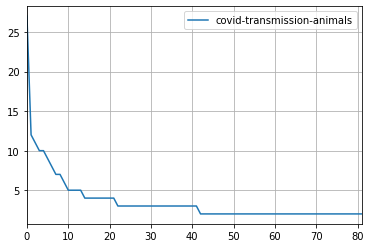

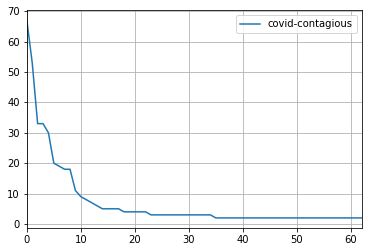

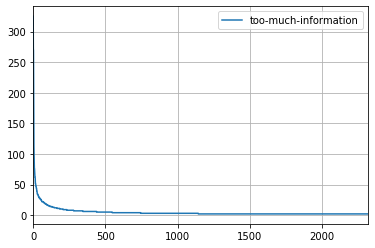

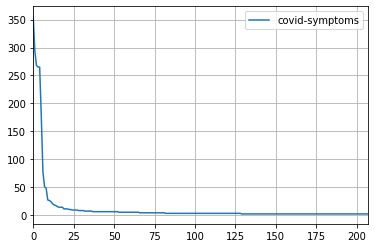

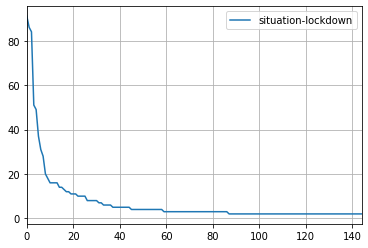

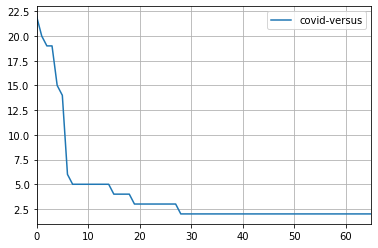

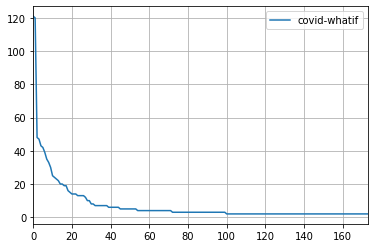

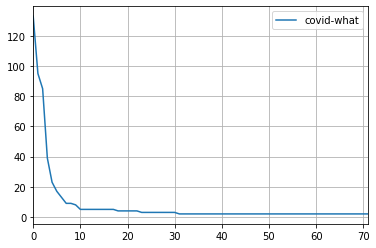

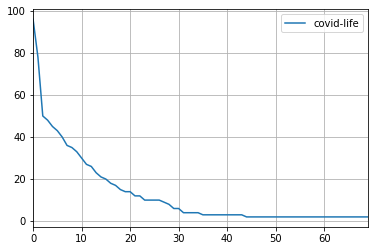

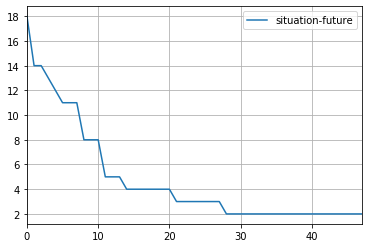

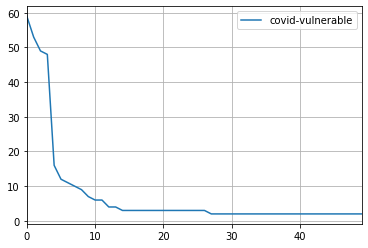

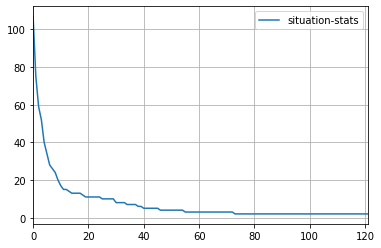

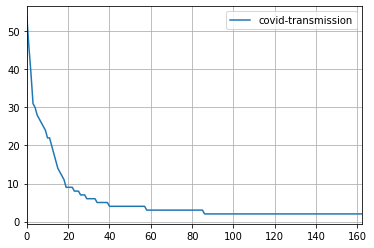

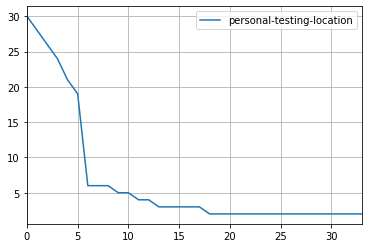

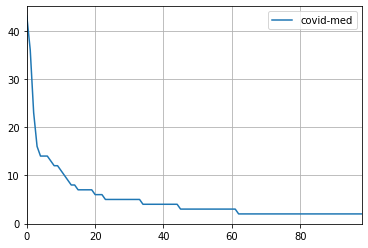

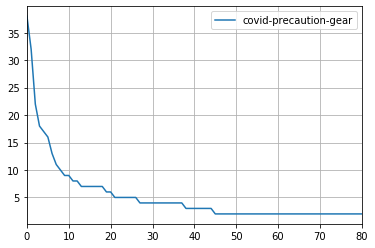

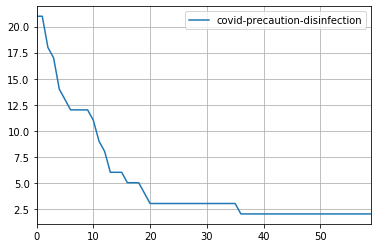

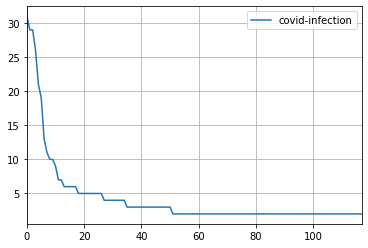

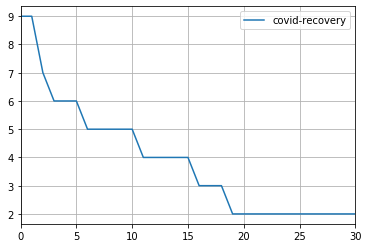

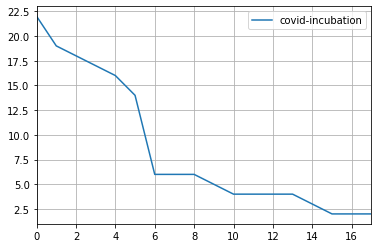

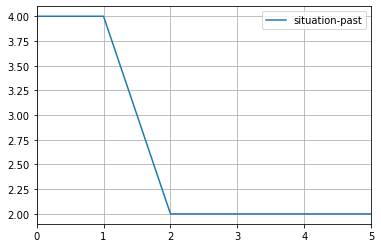

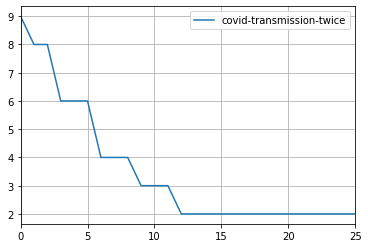

In [303]:
for feature in features:
    print(f"\n{feature} [{len(dataset[dataset.cluster == feature]):04}]\n{'-'*len(feature)}-------\n")
    dependency_counts[["Dependency",feature]].sort_values(by=feature, ascending=False)[dependency_counts[feature]>1].plot(use_index=False, grid=True)
    print(dependency_counts[["Dependency",feature]].sort_values(by=feature, ascending=False)[dependency_counts[feature]>1])

## Dependency based clustering using AHC

In [419]:
args.dep_min_freq = 3

In [412]:
dataset["dependency_vector"] = list(get_vectors(dataset.dependencies, dependency_counts[dependency_counts.total_freq>=args.dep_min_freq].Dependency.values.tolist()).toarray())

In [413]:
# dataset[dataset.cluster == "unclassified"].dependency_vector.to_numpy()

In [414]:
exp_df = dataset[["ques_en","cluster","dependencies","dependency_vector"]]

In [424]:
args.dist_thresh = 7

X = dataset.dependency_vector.values.tolist()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
exp_df["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(exp_df["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
exp_df.groupby("ahc_label")["ques_en"].count().sort_values()

Found 224 clusters


/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


ahc_label
223      1
181      1
183      1
146      1
203      1
      ... 
13     123
92     143
57     165
21     179
2      562
Name: ques_en, Length: 224, dtype: int64

In [428]:
args.n_clusters=50

X = dataset.dependency_vector.values.tolist()
clustering = KMeans(n_clusters=args.n_clusters).fit(X)
exp_df["kmeans_label"] = clustering.labels_

# Misc.
print(f"Found {args.n_clusters} clusters")
exp_df.groupby("kmeans_label")["ques_en"].count().sort_values()

Found 50 clusters


/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


kmeans_label
0        1
17       1
16       1
39       1
31       1
25       1
11       1
40       1
32       1
9        1
42       1
44       1
28       1
46       5
1        6
43       8
35       8
5        9
36      10
45      12
48      14
41      14
12      15
13      18
18      25
24      39
47      41
23      43
3       50
30      51
29      53
38      58
19      62
26      67
21      69
10      75
33      79
27      83
22      83
7       86
20      87
15      89
34      91
37     110
49     169
6      234
14     274
8      337
4      817
2     1451
Name: ques_en, dtype: int64

In [429]:
for label in exp_df.kmeans_label.unique():
    print(f"\ncluster #{label}, count - {len(exp_df[exp_df.kmeans_label==label])}")    
    print ("-------------------------------------------")  
    print(*exp_df[exp_df.kmeans_label==label][:10].ques_en.tolist(),sep="\n")
    print ("-------------------------------------------")  


cluster #4, count - 817
-------------------------------------------
What is Dialogue's position on sick notes?
Is the cough dry or oily?
is covid-19 dangerous
What range is the fever at normally if COVID-19 suspected?
why should i be in confinement
The question: are you traveling, is 
is migraines a symptom?
Is there an orientation for the personnel working in open area 
are my birds likely to catch covid-19
what is the covid
-------------------------------------------

cluster #1, count - 6
-------------------------------------------
What are Dialogue services?
What is the test administered for the diagnosis? how long does it take to get an answer? What is his measure of sensitivity?
What are the essential services? 
What are the essential services?
What is the list of essential services?
What are the services out there that can help families with disabilities during this time?
-------------------------------------------

cluster #2, count - 1451
-------------------------------------

In [423]:
for label in exp_df.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(exp_df[exp_df.ahc_label==label])}")    
    print ("-------------------------------------------")  
    print(*exp_df[exp_df.ahc_label==label][:10].ques_en.tolist(),sep="\n")
    print ("-------------------------------------------")  


cluster #15, count - 297
-------------------------------------------
What is Dialogue's position on sick notes?
What are Dialogue services?
what is the covid
What are the Symptome 
What are the criteria that will allow you to lift the state of sanitary emergency and containment instructions?
What are the Quebec statistics?  
is china responsible for the spreading of COVID-19?
What is an Asymptomatic Carrier?
What are the treatments ?
what are cov19 symptoms
-------------------------------------------

cluster #39, count - 830
-------------------------------------------
Should I practice social distancing? 
LP TEST question
I do not feel good
mental health
Should I work from home?
LP test question
something something this is jared testing
Can you describe the difference between dry cough and oily cough
My boyfriend works in the same garage as another whose step-parents are waiting for screening results, if they do not work side by side, does that put me at risk of seeing my boyfriend?


-------------------------------------------
How do people get infected with Coronavirus?
If I only have a sore throat and have not traveled can I be infected?
I sneezed yesterday. Am i infected
Can I infect someone if I don't have symptoms?
Which country infected ? 
Which country infected ? 
Can I get infected from food or grocery delivery?
Can I get infected after I healed from it?
Can you get be infected more than once? 
Can COVID-19 be infected more than once?
-------------------------------------------

cluster #46, count - 2
-------------------------------------------
I was in contact with a family member who came back from a trip 5 days ago, he is asymptomatic, I have a fever and I have been coughing since yesterday, should I get tested?
I have a very mild cough, I am not coming back from a trip and I have not been around anyone who came back from a trip. However, I suddenly have a fever. Can I take the screening test?
-------------------------------------------

cluster #24, cou

In [425]:
dataset = dataset.drop(columns=["ahc_label"], errors="ignore").join(exp_df["ahc_label"])
dataset = dataset.drop(columns=["kmeans_label"], errors="ignore").join(exp_df["kmeans_label"])

In [430]:
path = f"output/DepVecKmAhc_{args.n_clusters}c{args.dep_min_freq}mf{args.dist_thresh}dt_{args.suffix}.csv"
dataset.drop(features, axis="columns", errors="ignore").drop(["total"], axis="columns", errors="ignore").to_csv(path)
print(f"AHC on top of Dependency Vector output saved to {path}")

AHC on top of Dependency Vector output saved to output/DepVecKmAhc_50c3mf7dt_2020-04-21.csv


## LSA and AHC

In [ ]:
'''
    If considering NLTK tokenization of questions
'''
# Combining french translations and english questions in one column
eng = dataset[dataset.detected_lang == "en"].question.to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.to_frame(name="text")
d = eng.combine_first(french).dropna()

# Adding cluster information from rules
d["cluster"] = dataset.cluster

# Adding length as a feature
# d["len"] = dataset.len

# Selecting unclassified questions
d = d[d.cluster=="unclassified"] # May be also cluster too-much-information clusters

# Pre-processing
import nltk

stopwords_list = nltk.corpus.stopwords.words('english')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [nltk.word_tokenize(text) for text in texts]

In [ ]:
'''
    If considering the same preprocessing as used for rules above
'''
d = dataset[dataset.cluster=="unclassified"][["text","cluster","question","translated_question"]]

def bulk_tokenizer(texts):
     return [text.split() for text in texts]

In [ ]:
d.head()

In [ ]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

lsa_features = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()

use_len = False
if use_len:
    # Add len to the feature vector
    d[["embedding","len"]].apply(lambda x: x.embedding.append(x.len), axis=1)

    from sklearn import preprocessing

    x = d.embedding.tolist() #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    lsa_features = x_scaled
    
# Cluster
X = lsa_features
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["question"].count().sort_values()

In [ ]:
d.groupby("ahc_label")["text"].count().describe()

In [ ]:
d.text[d.text.str.contains("what should i do",case=False)]

In [ ]:
import spacy
from spacy import displacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_md")

In [ ]:
# for label in d.ahc_label.unique():
for label in d.ahc_label.unique():
    if len(d[d.ahc_label==label]) < 10:
        print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
        print ("-------------------------------------------")  
        docs = d[d.ahc_label==label].text.tolist()
        print(*docs,sep="\n")
        print ("-------------------------------------------")  
            
        
        for doc in docs:
            if type(doc) == str:
                doc = nlp_en(doc)
                print (doc)
                print ("-------------------------------------------")      
                displacy.render(doc, style='dep')
                for sentence in doc.sents:
#                     for root_child in sentence.root.children:
#                         if root_child.dep_ in ["advmod","aux"]:
#                             tuples.append([token.head.lemma_, root_child.lemma_])    
                    tuples = []
                    for token in sentence:
                        if "nsubj" in token.dep_:      
                            tuples.append([token.lemma_, token.head.lemma_])                
                            for sibling in token.head.children:
                                if sibling.dep_ in ["dobj","acomp"]:
                                    tuples.append([token.lemma_, token.head.lemma_, sibling.lemma_])  
                    for svo in tuples:
                        print(*svo,sep=" --> ") 
    #                         print([child.text for child in token.head.children])
        #                 print ( token.head.text, token.head.lemma_, token.head.tag_, token.head.i, token.dep_, token.i, token.text, token.lemma_, token.tag_, sep="\t")  
                print ("-------------------------------------------")


In [ ]:
dataset = dataset.drop(columns=["ahc_label"], errors="ignore").join(d["ahc_label"])

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}.csv"
dataset.drop(features, axis="columns", errors="ignore").drop(["total"], axis="columns", errors="ignore").to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

## LSA and AHC - 2nd Time

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}_checked.csv"
print(path)

In [ ]:
d = pd.read_csv(path, index_col=0)

In [ ]:
d = d[["question","text", "translation", "cluster", "tags", "ahc_label", "cluster_count"]]

In [ ]:
d.head()

In [ ]:
d = create_rules_based_clusters(d, cluster_col="cluster_2")

In [ ]:
d.head()

In [ ]:
# import nltk
# stopwords_list = nltk.corpus.stopwords.words('english')
# wn_lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [text.split() for text in texts]

In [ ]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

# Cluster
X = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["text"].count().sort_values()

In [ ]:
d.groupby("ahc_label")["text"].count().describe()

In [ ]:
# To Translated
# print(*d.text.tolist(),sep="\n")

In [ ]:
for label in d.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
    print(*zip(d[d.ahc_label==label][:10].question.tolist(),d[d.ahc_label==label][:10].text.tolist()),sep="\n")

In [ ]:
dataset.head()

In [ ]:
dataset = dataset.drop(features, axis="columns").drop("total", axis="columns").join(d["ahc_label"])

In [ ]:
dataset.head()

In [ ]:
# print(*dataset.question.tolist(),sep="\n")

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

## Iterative Clustering